# Выбор локации для скважины

# Содержание

**[1. Загрузка и подготовка данных](#step1)**

**[2. Обучение и проверка модели](#step2)**

**[3. Подготовка к расчёту прибыли](#step3)**

**[4. Расчёт прибыли и рисков](#step4)**

**[5. Вывод](#step5)**



Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

<a id='step1'></a>  **Загрузка и подготовка данных**

In [ ]:
import pandas as pd # импорт библиотеки pandas 
import matplotlib.pyplot as plt # импорт библиотеки matplotlib
plt.style.use('seaborn-pastel')
import seaborn as sns # импорт библиотеки seaborn
import numpy as np # импорт библиотеки nump
from scipy import stats as st # импорт библиотеки scipy
from sklearn.linear_model import LinearRegression # импорт линейной регрессии
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import train_test_split # импорт разделителя
from sklearn.utils import shuffle # импорт шаффла для перемешивания

%matplotlib inline

/var/folders/w8/whz827qx38v0ln9s213kypp00000gp/T/ipykernel_9532/3786944614.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-pastel')


In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

/var/folders/w8/whz827qx38v0ln9s213kypp00000gp/T/ipykernel_9532/912229180.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


Для обхода ключей создаётся представление ключей словаря, по сути являющееся генератором. Копия данных не создаётся.
Загрузим данные и создадим список ключей.

In [2]:
geo_data_0 = pd.read_csv('datasets/geo_data_0.csv')
geo_data_1 = pd.read_csv('datasets/geo_data_1.csv')
geo_data_2 = pd.read_csv('datasets/geo_data_2.csv')

geo_data = {'geo_0': geo_data_0,
               'geo_1': geo_data_1,
               'geo_2': geo_data_2,}

Посмотрим дубликаты. Для этого напишем функцию для подсчета и вывода дубликатов на экран.

In [3]:
for geo in geo_data:
    geo_data[geo].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null 

Пропусков нет ни в одном из датасетов.

Напишем функцию для оценки дубликатов. 

In [4]:
for geo in geo_data:
    duplicated_id = pd.DataFrame(columns=geo_data_0.columns)
    display(geo)
    for i in geo_data[geo][geo_data[geo]['id'].duplicated()]['id'].values:
        duplicated_id = pd.concat([duplicated_id] 
                                  + [geo_data[geo][geo_data[geo]['id'] == i]])
    display(duplicated_id)

'geo_0'

,id,f0,f1,f2,product
931,HZww2,0.755284,0.368511,1.863211,30.681774
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
1364,bxg6G,0.411645,0.856830,-3.653440,73.604260
41724,bxg6G,-0.823752,0.546319,3.630479,93.007798
3389,A5aEY,-0.039949,0.156872,0.209861,89.249364
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205
1949,QcMuo,0.506563,-0.323775,-2.215583,75.496502
63593,QcMuo,0.635635,-0.473422,0.862670,64.578675
64022,74z30,0.741456,0.459229,5.153109,140.771492
66136,74z30,1.084962,-0.312358,6.990771,127.643327


'geo_1'

,id,f0,f1,f2,product
1305,LHZR0,11.170835,-1.945066,3.002872,80.859783
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625
2721,bfPNe,-9.494442,-5.463692,4.006042,110.992147
82178,bfPNe,-6.202799,-4.820045,2.995107,84.038886
47591,wt4Uk,-9.091098,-8.109279,-0.002314,3.179103
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305
5849,5ltQ6,-3.435401,-12.296043,1.999796,57.085625
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044


'geo_2'

,id,f0,f1,f2,product
28039,xCHr8,1.633027,0.368135,-2.378367,6.120525
43233,xCHr8,-0.847066,2.101796,5.597130,184.388641
11449,VF7Jo,2.122656,-0.858275,5.746001,181.716817
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233420
45404,KUPhW,0.231846,-1.698941,4.990775,11.716299
55967,KUPhW,1.211150,3.176408,5.543540,132.831802
44378,Vcm5J,-1.229484,-2.439204,1.222909,137.968290
95090,Vcm5J,2.587702,1.986875,2.482245,92.327572


Ну чтож!

В регионах дубликаты в параметрах id не влияют на остальные параметры. Быть может, что одинаковый id значит лишь то, что использовали иной метод добычи или иную технологию. Возможно, что это ошибка при зaполнении датасета.

Удалим столбец id, для комфортного обучения будущей модели:

In [5]:
geo_data_0 = geo_data_0.drop(['id'], axis=1)
geo_data_1 = geo_data_1.drop(['id'], axis=1)
geo_data_2 = geo_data_2.drop(['id'], axis=1)

In [6]:
def distributed_features(seria, bins, xlim_max, ylim_max):
    plt.figure(figsize=[15,5])
    plt.hist(seria, bins=bins)
    plt.xlim([0,xlim_max])
    plt.ylim([0,ylim_max])
    plt.xlabel("Объем нефти на одну скважину, тыс. барелей")
    plt.ylabel("Кол-во скважин")
    plt.title("Гистограмма распределений признаков")
    plt.show()

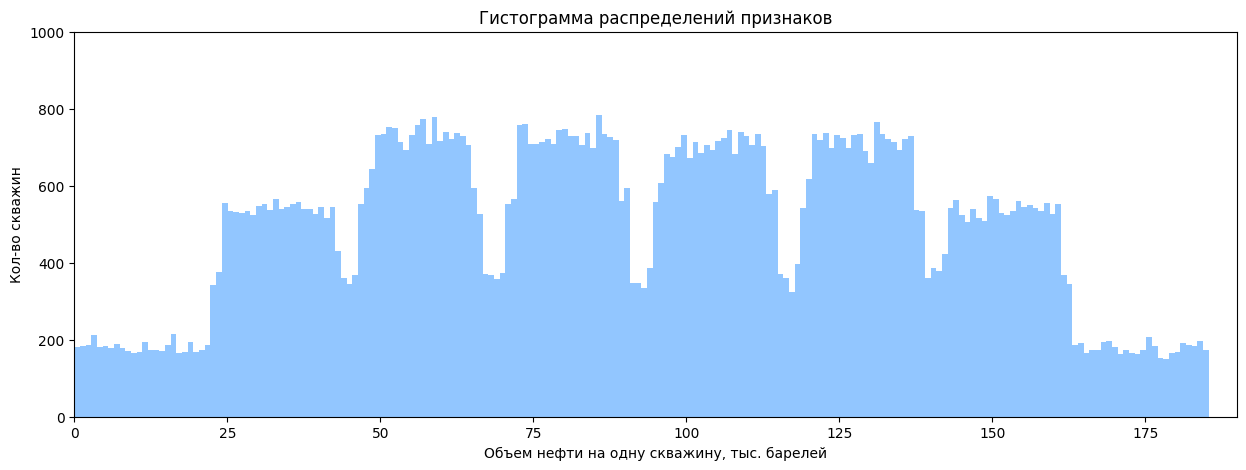

In [7]:

distributed_features(geo_data_0['product'], 200, 190, 1000)


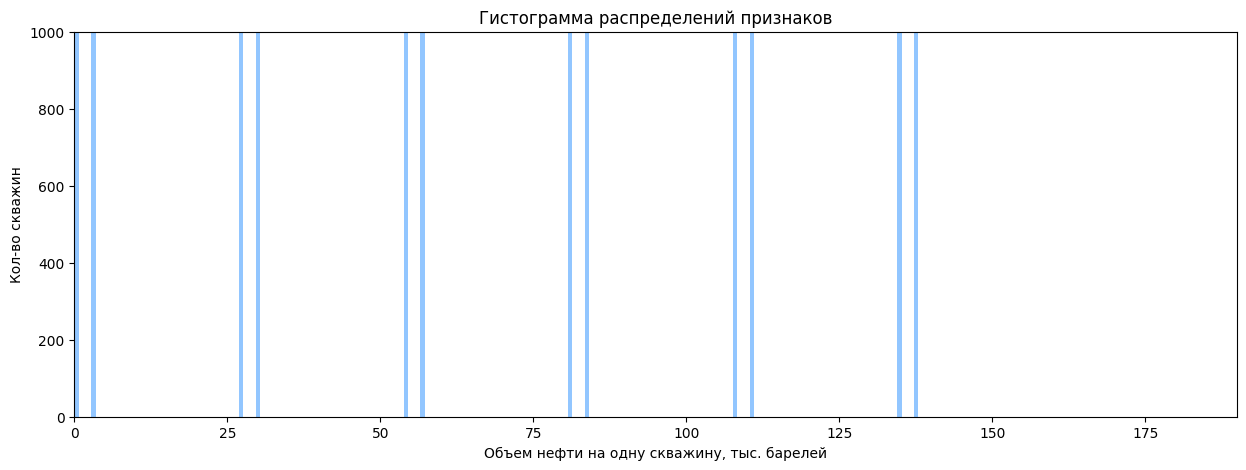

In [8]:

distributed_features(geo_data_1['product'], 200, 190, 1000)

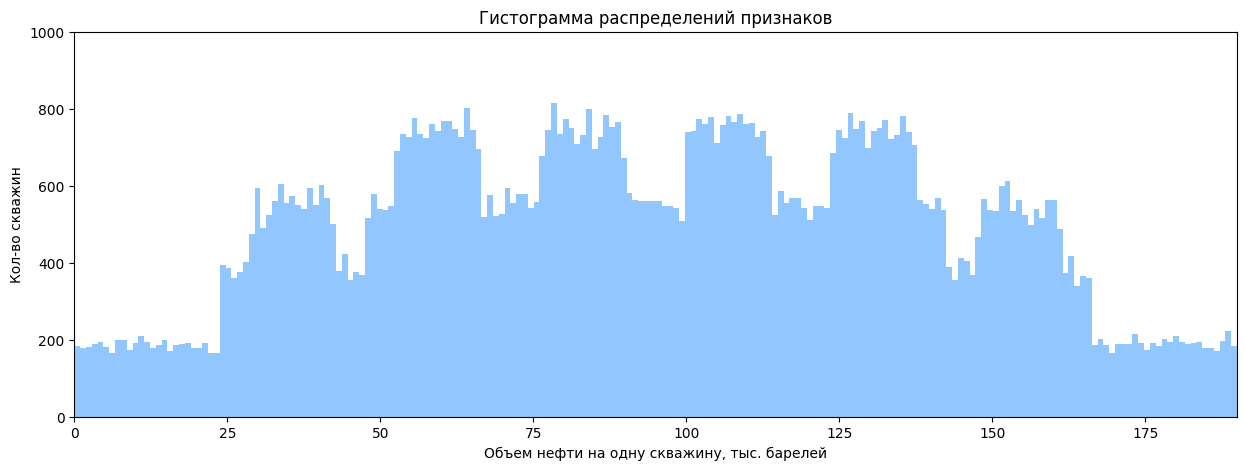

In [9]:
distributed_features(geo_data_2['product'], 200, 190, 1000)

Похоже, что второй регион странным образом распределен, то ли у них стратегия по запуску работ какая-то специфическая, то ли данные, которые мы наблюдаем, искуственно созданы. По первому и третьему региону вопросов нет.

In [10]:
corr_data = geo_data_0.corr()
corr_data

,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


In [11]:
corr_data = geo_data_1.corr()
corr_data

,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


In [12]:
corr_data = geo_data_2.corr()
corr_data

,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


В нулевом датафрейме признаки f0 и f1 имеют отрицательную корреляцию, f2 слабо положительно коррелирует с целевым признаком. В первом датафрейме очень сильно коррелирует целевой признак и f2. Во втором датафрейме есть коррелирующие признаки - f2 и product.

Я бы указала заказчику на корреляцию.

<a id='step2'></a>  **Обучение и проверка модели**


Обучите и проверьте модель для каждого региона:  
Разбейте данные на обучающую и валидационную выборки в соотношении 75:25.  
Обучите модель и сделайте предсказания на валидационной выборке.  
Сохраните предсказания и правильные ответы на валидационной выборке.  
Напечатайте на экране средний запас предсказанного сырья и RMSE модели.  
Проанализируйте результаты.  


MSE – одна из самых популярных метрик в задаче регрессии. Она уже знакома нам, т.к. применялась в качестве функции потерь в тренажере Яндекс-Практикума во многих ранее рассмотренных методах.  

Иногда для того, чтобы показатель эффективности MSE имел размерность исходных данных, из него извлекают квадратный корень и получают показатель эффективности RMSE.  

Создадим функцию для подсчета метрики RMSE.



In [13]:
# используем sklearn метрику mean_squared_error
def rmse(target_valid, predictions_valid):
    x = mean_squared_error(target_valid, predictions_valid)**0.5
    return x

Поскольку мы имеем три датасета, то нам будет удобно выполнить функцию в которой:  
 - выделяем параметры и таргет    
 - делим на валидационную и обучающую   
 - обучаем модель и сохраняем результат  
 - считаем RMSE  

In [14]:
def all_regions(data):
    # выделяем features и target
    features = data.drop('product', axis=1)
    target = data['product']
    # делим на валидационную и обучающую выборки
    features_train, features_valid, target_train, target_valid = train_test_split(features,
    target, test_size=0.25, random_state=12345)
    # обучаем модель Linear Regression
    model = LinearRegression()
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    # записываем в переменную rmse_data результат функции rmse 
    rmse_data = rmse(target_valid, predictions)
    return target_valid, predictions, rmse_data

In [15]:
# применяем функцию all_regions для трех регионов
geo_data_0_tt_valid, predictions_0_valid, rmse_0 = all_regions(geo_data_0)
geo_data_1_tt_valid, predictions_1_valid, rmse_1 = all_regions(geo_data_1)
geo_data_2_tt_valid, predictions_2_valid, rmse_2 = all_regions(geo_data_2)

In [16]:
print('RMSE:', rmse_0)
print('RMSE:', rmse_1)
print('RMSE:', rmse_2)

RMSE: 37.5794217150813
RMSE: 0.8930992867756165
RMSE: 40.02970873393434


In [17]:
mean_product_0 = predictions_0_valid.mean()
mean_product_1 = predictions_1_valid.mean()
mean_product_2 = predictions_2_valid.mean()

In [18]:
print('Cредний запас предсказанного сырья 1 региона: ', round(mean_product_0, 2))
print('Cредний запас предсказанного сырья 2 региона: ', round(mean_product_1, 2))
print('Cредний запас предсказанного сырья 3 региона: ', round(mean_product_2, 2))

Cредний запас предсказанного сырья 1 региона:  92.59
Cредний запас предсказанного сырья 2 региона:  68.73
Cредний запас предсказанного сырья 3 региона:  94.97


Самый лучший показатель эффективности получается у модели второго региона. Это тот, который geo_data_1 с RMSE равным 0.893099286775617. 

<a id='step3'></a>  **Подготовка к расчёту прибыли**

Все ключевые значения для расчётов сохраните в отдельных переменных.  
Рассчитайте достаточный объём сырья для безубыточной разработки новой скважины. Сравните полученный объём сырья со средним запасом в каждом регионе.   
Напишите выводы по этапу подготовки расчёта прибыли.  

При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки. 

Бюджет на разработку скважин в регионе — 10 млрд рублей.  

При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей,   поскольку объём указан в тысячах баррелей.  

После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.   

Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.    

In [19]:
bores_number = 500 
bores_needed = 200
budget = 10000000000 / 1000000 # в млн. руб.
barrel_price = 450000 / 1000000 # в млн. руб.
risk = 2.5 

Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины.

Выведем на экран среднее значение и проанализируем результат:

In [20]:
# считаем среднюю прибыль на лучшую точку
average_profit_per_point = budget / bores_needed
print(f'Средняя прибыль на лучшую точку: {average_profit_per_point} тыс.руб.')
print('')

Средняя прибыль на лучшую точку: 50.0 тыс.руб.



In [21]:
# считаем средний объем нефти на регион
average_barrels = budget / barrel_price

print(f'Средний объем нефти на регион: {average_barrels} тыс.барелей')
print('')

Средний объем нефти на регион: 22222.222222222223 тыс.барелей



In [22]:
product_needed = budget / bores_needed / barrel_price

print(f'Необходимый средний объём одной скважины, чтобы она была не убыточна: {product_needed}')
print('')


Необходимый средний объём одной скважины, чтобы она была не убыточна: 111.11111111111111



In [23]:
for geo in geo_data:
    x = geo_data[geo]['product'].mean()
    if x > product_needed:
        print(f'Средний объём сырья в {geo} не убыточный: {round(x, 3)}')
    else: 
        print(f'Средний объём сырья в {geo} убыточен: {round(x, 3)}')

Средний объём сырья в geo_0 убыточен: 92.5
Средний объём сырья в geo_1 убыточен: 68.825
Средний объём сырья в geo_2 убыточен: 95.0


Вывод:  

Анализ средних объемов на скважину для каждого региона показал, что для первого и третьего - высокая вероятность окупить затраты.
Рaзброс знaчений вокруг среднего 92.5 и 95 говорит нaм о том, что существует достаточно много сквaжин, где зaпасы больше необходимого среднего.

Во вторых дaнных возможно есть определенный смысл - значений больше 111 достаточно много и при определенной доли везения можно выбрать только лучшие в этой выбoрке, хотя и среднее знaчение 68.8.

<a id='step4'></a>  **Расчёт прибыли и рисков** 

Напишите функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:  
Выберите скважины с максимальными значениями предсказаний.   
Просуммируйте целевое значение объёма сырья, соответствующее этим предсказаниям.  
Рассчитайте прибыль для полученного объёма сырья.  
Посчитайте риски и прибыль для каждого региона:  
Примените технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.  
Найдите среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.  
Напишите выводы: предложите регион для разработки скважин и обоснуйте выбор.  

In [24]:
# преобразуем результаты предсказаний в Pandas Series
predictions_0_valid = pd.Series(predictions_0_valid)
predictions_1_valid = pd.Series(predictions_1_valid)
predictions_2_valid = pd.Series(predictions_2_valid)

In [25]:
# создаём функцию для подсчета прибыли в трех регионах
def revenue_profit(target, bores, count, budget):
     # сортируем по предсказанию
    bores_sorted = bores.sort_values(ascending=False)
     # выбираем лучшие по индексам
    selected = target[bores_sorted.index][:count]
     # считаем заработок с выбранных скважин
    revenue = barrel_price * selected.sum()
    # считаем прибыль
    profit = revenue - budget 
    return profit

Посчитаем риски и прибыль для каждого региона.  

Вычислить сложные величины, не прибегая к формулам, поможет техника Bootstrap (англ. «самовытягивание»).
Разберём, как она работает.
Чтобы получить нужную величину, например, среднее, из исходного набора данных формируют подвыборки (псевдовыборки). На каждой из них и вычисляют среднее.  
Теоретически формировать подвыборки и рассчитывать по ним нужную величину можно многократно. Так мы получим несколько значений интересующего показателя и оценим распределение.  

Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.   

Найдём среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.  
Напишем выводы: предложим регион для разработки скважин и обоснуем выбор.   

Создаём функцию для подсчета результатов:    

In [26]:
def total_region(target, predictions):
    # создаём список
    values = []

    # применяем Bootstrap
    state = np.random.RandomState(12345)
    for i in range(1000): 
        target_subsample = target.reset_index(drop=True).sample(n=bores_number, replace=True, random_state=state)
        pred_subsample = predictions[target_subsample.index]
        # выбираем 200 скважин
        value = revenue_profit(target_subsample, pred_subsample, bores_needed, budget) 
        values.append(value)

    # считаем количество убытков
    values = pd.Series(values)
    risk = (values < 0).mean()

    # считаем доверительный интервал
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)

    # выводим результат на экран
    print('Средняя прибыль в регионе:', round(values.mean(), 2), 'млн. руб')
    print(f'95% доверительный интервал: ({lower}, {upper})')
    print('Риск убытков: {:.1%}'.format((values < 0).mean()))

    # сравниваем с необходимым риском
    if (risk * 100) <= 2.5:
          print('Риск убытков меньше необходимого значения. Оставляем регион.')
    else:
          print('Риск убытков больше необходимого значения.')      



In [27]:
total_region(geo_data_0_tt_valid, predictions_0_valid)

Средняя прибыль в регионе: 425.94 млн. руб
95% доверительный интервал: (-102.09009483793592, 947.976353358369)
Риск убытков: 6.0%
Риск убытков больше необходимого значения.


In [28]:
total_region(geo_data_1_tt_valid, predictions_1_valid)

Средняя прибыль в регионе: 515.22 млн. руб
95% доверительный интервал: (68.87322537050254, 931.547591257049)
Риск убытков: 1.0%
Риск убытков меньше необходимого значения. Оставляем регион.


In [29]:
total_region(geo_data_2_tt_valid, predictions_2_valid)

Средняя прибыль в регионе: 435.01 млн. руб
95% доверительный интервал: (-128.88054732978893, 969.7069541802657)
Риск убытков: 6.4%
Риск убытков больше необходимого значения.


<a id='step5'></a>  **Вывод:**

При выполнении следующего проекта было выполнено:  

Изучены данные. Проведена подготовкa данных к моделировaнию.  
Обучена модель для кaждого региона geo_data_0, geo_data_1 и geo_data_2.  
Составлена функция расчета прибыли в регионе.  
Посчитана прибыль и риски за каждый регион и обоснован выбор региона.  
Второй регион получился одним из лучших по показателям предсказания.    


Самый лучший показатель эффективности rmse получился у модели второго региона.  
По двум регионам из трех средняя прибыль меньше, а так же вероятность убытков выше.   
Мы не будем рассматривать их для разработки.  

Второй регион нам вполне подходит, так как риск убытков ниже и средняя прибыль выше, чем у остальных регионов.   
Тем более доверительный интервал показывает, что даже при не очень удачном выборе разработка скважин окупится.

